In [47]:
import pandas as pd
from tensorflow.keras import layers, models, regularizers
import numpy as np
from sklearn.model_selection import train_test_split, KFold
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import tensorflow as tf

from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.optimizers import Adam

In [48]:
path_csvs = "D:/mestrado/notebooks/dados/features_csv"
cols_to_scale = ['RMSE', 'ZCR', 'COEF_1', 'COEF_2', 'COEF_3', 'COEF_4', 'COEF_5', 'COEF_6', 'COEF_7', 'COEF_8', 'COEF_9', 'COEF_10', 'COEF_11', 'COEF_12', 'COEF_13', 'COEF_14', 'COEF_15', 'COEF_16', 'COEF_17', 'COEF_18', 'COEF_19', 'COEF_20']

In [49]:
df_feminino_completo_normalizado = pd.read_csv("D:/mestrado/notebooks/dados/features_csv/feminino_completo_normalizado_balanceado.csv", sep=";")


### Criando Tensor

In [50]:
def dataframe_to_tensor(df, num_features):
    grouped = df.groupby("Audio")
    # Cria uma lista de arrays, um para cada áudio
    tensors = [group.iloc[:, :num_features].values for _, group in grouped]
    return np.array(tensors)  # Converte para um tensor 3D

In [51]:
# Função para padronizar as sequências (com padding ou truncamento)
def standardize_frames(sequences, max_frames):
    standardized_sequences = []
    for seq in sequences:
        if len(seq) < max_frames:
            # Padding: Adiciona zeros ao final da sequência
            padded_seq = np.pad(seq, ((0, max_frames - len(seq)), (0, 0)), mode='constant')
            standardized_sequences.append(padded_seq)
        else:
            # Truncamento: Corta a sequência para o tamanho máximo
            truncated_seq = seq[:max_frames, :]
            standardized_sequences.append(truncated_seq)
    return np.array(standardized_sequences)

In [52]:
grouped = df_feminino_completo_normalizado.groupby("Audio")
df_frames = pd.DataFrame()
df_frames['frames'] = df_feminino_completo_normalizado.groupby("Audio").size()

In [53]:
### Verifica a quantidade de audios por classe

df_feminino_completo_normalizado
contagem = df_feminino_completo_normalizado['Audio'].nunique()
print("Existem ", contagem, "áudios.")

df_distintos = df_feminino_completo_normalizado.drop_duplicates(subset='Audio')
contagem_categoria = df_distintos['Label Multiclasse'].value_counts()
print("Relação de áudios por classe:")
print(contagem_categoria)

assert len(set(contagem_categoria)) == 1


Existem  1250 áudios.
Relação de áudios por classe:
Label Multiclasse
disfonia     250
paralisia    250
laringite    250
polipo       250
saudavel     250
Name: count, dtype: int64


In [54]:
df_frames.head()
print(df_frames['frames'].sum())
numero_max_frames = int(df_frames['frames'].mean())
print('numero_max_frames ', numero_max_frames)

114496
numero_max_frames  91


In [55]:
def extract_y(df):
    num_features = 23  # RMS (1) + ZCR (1) + 20 MFCCs
    grouped = df.groupby("Audio")

    # Converta cada áudio para uma matriz (frames x features)
    sequences = [group.iloc[:, :num_features].values for _, group in grouped]

    # Padronize os frames
    max_frames = numero_max_frames  # Defina o número fixo de frames
    tensor = standardize_frames(sequences, max_frames)

    print("Shape do tensor:", tensor.shape)  # Deve ser (num_audios, max_frames, num_features)

    y = []
    for s in sequences:
        for element in s[0]:
            if isinstance(element, str): 
                if 'saudavel' in element:
                        y.append(0)
                elif 'disfonia' in element:
                     y.append(1)
                elif 'laringite' in element:
                     y.append(2)
                elif 'paralisia' in element:
                     y.append(3)
                elif 'polipo' in element:
                     y.append(4)
                else:
                    y.append(None)
                break
            
    print('Len(y)')
    print(len(y))

    none_indexes = [i for i, val in enumerate(y) if val == None]
    # print result
    print("The None indices list is : " + str(none_indexes))
    assert len(none_indexes) == 0

    # Transformação para one-hot
    one_hot_labels = tf.keras.utils.to_categorical(y, num_classes=5)
    print(one_hot_labels)

    return one_hot_labels


In [56]:
def extract_tensor_x(df):
    num_features = 22  # RMS (1) + ZCR (1) + 20 MFCCs
    # Agrupe o DataFrame por áudio
    grouped = df.groupby("Audio")

    # Converta cada áudio para uma matriz (frames x features)
    sequences = [group.iloc[:, :num_features].values for _, group in grouped]

    # Padronize os frames
    max_frames = numero_max_frames  # Defina o número fixo de frames
    tensor = standardize_frames(sequences, max_frames)

    print("Shape do tensor:", tensor.shape)  # Deve ser (num_audios, max_frames, num_features)
    return tensor


### Criando a Rede Neural

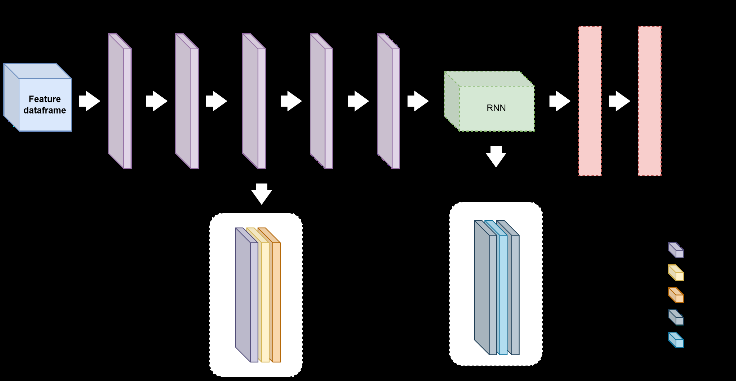

In [11]:
def generate_model_grid_search(learning_rate=0.001, dropout_rate=0.2, lstm_units=128):


    print("Iniciando o modelo com os seguintes parâmetros: Learning Rate - ", learning_rate, " Dropout - ", dropout_rate, " LSTM Units - ", lstm_units)

    # Dimensão das features (exemplo: 20 MFCCs + RMS + ZCR -> 22 features por timestep)
    input_shape = (None, 22)  # None -> Sequência variável, 22 -> Features por timestep

    # Regularização L2 (lambda = 0.01)
    l2_reg = regularizers.L2(0.005)

    # Entrada
    inputs = layers.Input(shape=input_shape)

    # 5 Blocos CNN
    x = inputs
    for _ in range(6):
        x = layers.Conv1D(128, kernel_size=3, padding="same", activation="relu", kernel_regularizer=l2_reg)(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling1D(pool_size=2)(x)
        x = layers.Dropout(dropout_rate)(x)  # Dropout adicional
        # print("Após bloco CNN:", x.shape)

    # print(x.shape)

    # LSTM com regularização L2
    x = layers.LSTM(lstm_units, return_sequences=True, kernel_regularizer=l2_reg)(x)
    # print("Após LSTM (return_sequences=True):", x.shape)

    # Multi-Head Attention
    # attention = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)  # 4 cabeças de atenção
    # x = layers.Add()([x, attention])  # Resíduo para estabilizar treinamento
    #print("Após Multi-Head Attention:", x.shape)

    # Atenção Personalizada
    query = layers.Dense(256, activation="tanh")(x)  # Projeta a sequência
    key = layers.Dense(256, activation="tanh")(x)    # Projeta a sequência
    score = layers.Dot(axes=[2, 2])([query, key])    # Produto escalar
    attention_weights = layers.Softmax()(score)     # Pesos normalizados
    context = layers.Dot(axes=[2, 1])([attention_weights, x])  # Combina pesos com sequência

    # Skip connection
    x = layers.Add()([x, context])


    # LSTM final para resumir a sequência
    x = layers.LSTM(lstm_units, kernel_regularizer=l2_reg)(x)
    # print("Após LSTM final:", x.shape)

    # Camadas densas para classificação com regularização e Dropout
    x = layers.Dense(128, activation="relu", kernel_regularizer=l2_reg)(x)
    x = layers.Dropout(dropout_rate)(x)
    # print("Após Dense:", x.shape)

    # Camada de saída multiclasse
    num_classes = 5
    outputs = layers.Dense(num_classes, activation="softmax", kernel_regularizer=l2_reg)(x)
    # print("Saída:", outputs.shape)

    # Construção do modelo
    model = models.Model(inputs, outputs)

    # Compilação
    #optimizer = Adam(learning_rate=1e-3)  # Taxa de aprendizado inicial
    # Learning Rate default do Adam = 0.001
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss="categorical_crossentropy", metrics=["accuracy", "categorical_accuracy",  "precision", "recall"])
    return model


In [57]:
# dividindo tensor entre treino, validação e teste
X = extract_tensor_x(df_feminino_completo_normalizado)
y = extract_y(df_feminino_completo_normalizado)

assert len(y) == 1250
assert X.shape[0] == len(y)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

Shape do tensor: (1250, 91, 22)
Shape do tensor: (1250, 91, 23)
Len(y)
1250
The None indices list is : []
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [161]:

params_grid = {
    'batch_size': [32, 64],
    'epochs': [20],
    'model__learning_rate': [0.001, 0.0005],
    'model__dropout_rate': [0.2],
    'model__lstm_units': [128, 256]
}

# Criação do modelo
model = KerasClassifier(build_fn=generate_model_grid_search, verbose=1)

# GridSearchCV
grid = GridSearchCV(
    estimator=model,
    param_grid=params_grid,
    scoring="accuracy",
    cv=3  # 3-fold cross-validation
)

# Ajuste dos dados
grid_result = grid.fit(X_train, y_train)


Iniciando o modelo com os seguintes parâmetros: Learning Rate -  0.001  Dropout -  0.2  LSTM Units -  128
Epoch 1/20


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.2631 - categorical_accuracy: 0.2631 - loss: 7.2639 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6575 - categorical_accuracy: 0.6575 - loss: 5.4761 - precision: 0.2689 - recall: 0.0058      
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7350 - categorical_accuracy: 0.7350 - loss: 3.9114 - precision: 0.8657 - recall: 0.3522
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8282 - categorical_accuracy: 0.8282 - loss: 3.0939 - precision: 0.8646 - recall: 0.7183
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8586 - categorical_accuracy: 0.8586 - loss: 2.6692 - precision: 0.8874 - recall: 0.8246
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8762 - categorical_accuracy: 0.8762 - loss: 2.4251 - precision: 0.8902 - recall: 0.8518
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8811 - categor

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
Iniciando o modelo com os seguintes parâmetros: Learning Rate -  0.001  Dropout -  0.2  LSTM Units -  128
Epoch 1/20


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.3345 - categorical_accuracy: 0.3345 - loss: 7.2846 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6521 - categorical_accuracy: 0.6521 - loss: 5.5137 - precision: 0.3839 - recall: 0.0168     
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6994 - categorical_accuracy: 0.6994 - loss: 4.1326 - precision: 0.8277 - recall: 0.3764
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8248 - categorical_accuracy: 0.8248 - loss: 3.3307 - precision: 0.8723 - recall: 0.7310
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7985 - categorical_accuracy: 0.7985 - loss: 3.0085 - precision: 0.8259 - recall: 0.7653
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8503 - categorical_accuracy: 0.8503 - loss: 2.6905 - precision: 0.8846 - recall: 0.8171
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8991 - categori

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
Iniciando o modelo com os seguintes parâmetros: Learning Rate -  0.001  Dropout -  0.2  LSTM Units -  128
Epoch 1/20


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.2848 - categorical_accuracy: 0.2848 - loss: 7.2716 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6325 - categorical_accuracy: 0.6325 - loss: 5.5496 - precision: 0.3650 - recall: 0.0072     
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7628 - categorical_accuracy: 0.7628 - loss: 4.0267 - precision: 0.9039 - recall: 0.4295
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8390 - categorical_accuracy: 0.8390 - loss: 3.2151 - precision: 0.8748 - recall: 0.7671
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8854 - categorical_accuracy: 0.8854 - loss: 2.8561 - precision: 0.9008 - recall: 0.8611
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8873 - categorical_accuracy: 0.8873 - loss: 2.5629 - precision: 0.9076 - recall: 0.8464
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9081 - categori

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
Iniciando o modelo com os seguintes parâmetros: Learning Rate -  0.001  Dropout -  0.2  LSTM Units -  256
Epoch 1/20


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.3090 - categorical_accuracy: 0.3090 - loss: 8.3106 - precision: 0.0333 - recall: 1.7153e-04   
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5674 - categorical_accuracy: 0.5674 - loss: 5.6714 - precision: 0.7636 - recall: 0.2476
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7702 - categorical_accuracy: 0.7702 - loss: 4.0880 - precision: 0.8786 - recall: 0.5848
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8208 - categorical_accuracy: 0.8208 - loss: 3.3855 - precision: 0.8553 - recall: 0.7846
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8846 - categorical_accuracy: 0.8846 - loss: 2.9438 - precision: 0.9184 - recall: 0.8455
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8921 - categorical_accuracy: 0.8921 - loss: 2.6552 - precision: 0.9254 - recall: 0.8691
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8969 - categorical_ac

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
Iniciando o modelo com os seguintes parâmetros: Learning Rate -  0.001  Dropout -  0.2  LSTM Units -  256
Epoch 1/20


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.2782 - categorical_accuracy: 0.2782 - loss: 8.3415 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5942 - categorical_accuracy: 0.5942 - loss: 5.6660 - precision: 0.8361 - recall: 0.2030
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7403 - categorical_accuracy: 0.7403 - loss: 4.0768 - precision: 0.8296 - recall: 0.6157
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8070 - categorical_accuracy: 0.8070 - loss: 3.3591 - precision: 0.8450 - recall: 0.7592
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8383 - categorical_accuracy: 0.8383 - loss: 2.9756 - precision: 0.8681 - recall: 0.8006
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8742 - categorical_accuracy: 0.8742 - loss: 2.6578 - precision: 0.9030 - recall: 0.8562
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8659 - categorical_a

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
Iniciando o modelo com os seguintes parâmetros: Learning Rate -  0.001  Dropout -  0.2  LSTM Units -  256
Epoch 1/20


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.2784 - categorical_accuracy: 0.2784 - loss: 8.3369 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6191 - categorical_accuracy: 0.6191 - loss: 5.7126 - precision: 0.8655 - recall: 0.1349
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7763 - categorical_accuracy: 0.7763 - loss: 4.1118 - precision: 0.8659 - recall: 0.5759
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7877 - categorical_accuracy: 0.7877 - loss: 3.4175 - precision: 0.8414 - recall: 0.7536
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8456 - categorical_accuracy: 0.8456 - loss: 3.0615 - precision: 0.8620 - recall: 0.7981
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8843 - categorical_accuracy: 0.8843 - loss: 2.7354 - precision: 0.9062 - recall: 0.8712
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8941 - categorical_a

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
Iniciando o modelo com os seguintes parâmetros: Learning Rate -  0.0005  Dropout -  0.2  LSTM Units -  128
Epoch 1/20


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.2758 - categorical_accuracy: 0.2758 - loss: 7.5089 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4408 - categorical_accuracy: 0.4408 - loss: 6.5873 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4823 - categorical_accuracy: 0.4823 - loss: 5.7158 - precision: 0.7790 - recall: 0.0534 
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5426 - categorical_accuracy: 0.5426 - loss: 4.8767 - precision: 0.8431 - recall: 0.2664
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6703 - categorical_accuracy: 0.6703 - loss: 4.2737 - precision: 0.8785 - recall: 0.4114
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7866 - categorical_accuracy: 0.7866 - loss: 3.7401 - precision: 0.8815 - recall: 0.6494
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8476 - cate

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 6/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
Iniciando o modelo com os seguintes parâmetros: Learning Rate -  0.0005  Dropout -  0.2  LSTM Units -  128
Epoch 1/20


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.2588 - categorical_accuracy: 0.2588 - loss: 7.4923 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.4518 - categorical_accuracy: 0.4518 - loss: 6.5617 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5754 - categorical_accuracy: 0.5754 - loss: 5.6978 - precision: 0.2500 - recall: 0.0011      
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6420 - categorical_accuracy: 0.6420 - loss: 4.7659 - precision: 0.8596 - recall: 0.2800
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6753 - categorical_accuracy: 0.6753 - loss: 4.1130 - precision: 0.8318 - recall: 0.4138
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7974 - categorical_accuracy: 0.7974 - loss: 3.5732 - precision: 0.8653 - recall: 0.6478
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8426 -

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
Iniciando o modelo com os seguintes parâmetros: Learning Rate -  0.0005  Dropout -  0.2  LSTM Units -  128
Epoch 1/20


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.2590 - categorical_accuracy: 0.2590 - loss: 7.4802 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4717 - categorical_accuracy: 0.4717 - loss: 6.5584 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5905 - categorical_accuracy: 0.5905 - loss: 5.6990 - precision: 0.7698 - recall: 0.0474  
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7469 - categorical_accuracy: 0.7469 - loss: 4.8135 - precision: 0.8856 - recall: 0.2409
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8219 - categorical_accuracy: 0.8219 - loss: 4.0806 - precision: 0.8788 - recall: 0.5589
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9034 - categorical_accuracy: 0.9034 - loss: 3.5307 - precision: 0.9337 - recall: 0.8071
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9045 - cat

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
Iniciando o modelo com os seguintes parâmetros: Learning Rate -  0.0005  Dropout -  0.2  LSTM Units -  256
Epoch 1/20


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.2412 - categorical_accuracy: 0.2412 - loss: 8.6966 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5143 - categorical_accuracy: 0.5143 - loss: 7.1728 - precision: 0.4125 - recall: 0.0107    
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6747 - categorical_accuracy: 0.6747 - loss: 5.7692 - precision: 0.8363 - recall: 0.2770
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7929 - categorical_accuracy: 0.7929 - loss: 4.7552 - precision: 0.9180 - recall: 0.5905
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8705 - categorical_accuracy: 0.8705 - loss: 4.0891 - precision: 0.9065 - recall: 0.8316
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8939 - categorical_accuracy: 0.8939 - loss: 3.6765 - precision: 0.9088 - recall: 0.8823
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9207 - categoric

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 6/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
Iniciando o modelo com os seguintes parâmetros: Learning Rate -  0.0005  Dropout -  0.2  LSTM Units -  256
Epoch 1/20


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.2341 - categorical_accuracy: 0.2341 - loss: 8.6981 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5877 - categorical_accuracy: 0.5877 - loss: 7.2018 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6886 - categorical_accuracy: 0.6886 - loss: 5.7977 - precision: 0.8389 - recall: 0.1467
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8143 - categorical_accuracy: 0.8143 - loss: 4.6618 - precision: 0.8889 - recall: 0.6966
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8463 - categorical_accuracy: 0.8463 - loss: 4.1081 - precision: 0.8737 - recall: 0.7953
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8726 - categorical_accuracy: 0.8726 - loss: 3.7335 - precision: 0.8873 - recall: 0.8321
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8987 - categ

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
Iniciando o modelo com os seguintes parâmetros: Learning Rate -  0.0005  Dropout -  0.2  LSTM Units -  256
Epoch 1/20


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.2809 - categorical_accuracy: 0.2809 - loss: 8.6987 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5046 - categorical_accuracy: 0.5046 - loss: 7.2224 - precision: 0.3500 - recall: 0.0067     
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6054 - categorical_accuracy: 0.6054 - loss: 5.8716 - precision: 0.8772 - recall: 0.3085
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7108 - categorical_accuracy: 0.7108 - loss: 4.9297 - precision: 0.8894 - recall: 0.5227
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8065 - categorical_accuracy: 0.8065 - loss: 4.1790 - precision: 0.8918 - recall: 0.7134
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8889 - categorical_accuracy: 0.8889 - loss: 3.6680 - precision: 0.9219 - recall: 0.8580
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9092 - categori

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
Iniciando o modelo com os seguintes parâmetros: Learning Rate -  0.001  Dropout -  0.2  LSTM Units -  128
Epoch 1/20


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.2522 - categorical_accuracy: 0.2522 - loss: 7.4480 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4793 - categorical_accuracy: 0.4793 - loss: 6.3357 - precision: 0.3636 - recall: 0.0031      
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4903 - categorical_accuracy: 0.4903 - loss: 5.3256 - precision: 0.6722 - recall: 0.1567
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5947 - categorical_accuracy: 0.5947 - loss: 4.4418 - precision: 0.8032 - recall: 0.2793
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7446 - categorical_accuracy: 0.7446 - loss: 3.7932 - precision: 0.8434 - recall: 0.4835
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8526 - categorical_accuracy: 0.8526 - loss: 3.3557 - precision: 0.8777 - recall: 0.7744
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8698 - categor

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (64, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 324ms/step

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step
Iniciando o modelo com os seguintes parâmetros: Learning Rate -  0.001  Dropout -  0.2  LSTM Units -  128
Epoch 1/20


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.2525 - categorical_accuracy: 0.2525 - loss: 7.4718 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5038 - categorical_accuracy: 0.5038 - loss: 6.3807 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6562 - categorical_accuracy: 0.6562 - loss: 5.3953 - precision: 0.4311 - recall: 0.0065      
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7682 - categorical_accuracy: 0.7682 - loss: 4.4511 - precision: 0.9138 - recall: 0.2123
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8212 - categorical_accuracy: 0.8212 - loss: 3.6109 - precision: 0.9145 - recall: 0.6014
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8891 - categorical_accuracy: 0.8891 - loss: 3.1212 - precision: 0.9058 - recall: 0.8549
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8862 -

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (64, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 332ms/step

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
Iniciando o modelo com os seguintes parâmetros: Learning Rate -  0.001  Dropout -  0.2  LSTM Units -  128
Epoch 1/20


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.2558 - categorical_accuracy: 0.2558 - loss: 7.4646 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4603 - categorical_accuracy: 0.4603 - loss: 6.3627 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5815 - categorical_accuracy: 0.5815 - loss: 5.3525 - precision: 0.8112 - recall: 0.0815   
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7171 - categorical_accuracy: 0.7171 - loss: 4.4164 - precision: 0.9158 - recall: 0.3575
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8608 - categorical_accuracy: 0.8608 - loss: 3.6641 - precision: 0.9238 - recall: 0.6069
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8610 - categorical_accuracy: 0.8610 - loss: 3.2425 - precision: 0.8839 - recall: 0.8198
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8772 - ca

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (64, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step 

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
Iniciando o modelo com os seguintes parâmetros: Learning Rate -  0.001  Dropout -  0.2  LSTM Units -  256
Epoch 1/20


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.3127 - categorical_accuracy: 0.3127 - loss: 8.6329 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5465 - categorical_accuracy: 0.5465 - loss: 6.8506 - precision: 0.7084 - recall: 0.0674  
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6315 - categorical_accuracy: 0.6315 - loss: 5.4321 - precision: 0.7381 - recall: 0.3099
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7026 - categorical_accuracy: 0.7026 - loss: 4.4483 - precision: 0.8052 - recall: 0.6343
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7700 - categorical_accuracy: 0.7700 - loss: 3.8090 - precision: 0.8742 - recall: 0.6680
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8268 - categorical_accuracy: 0.8268 - loss: 3.3604 - precision: 0.8582 - recall: 0.7523
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8144 - categorical

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (64, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 358ms/step

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
Iniciando o modelo com os seguintes parâmetros: Learning Rate -  0.001  Dropout -  0.2  LSTM Units -  256
Epoch 1/20


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.2881 - categorical_accuracy: 0.2881 - loss: 8.6613 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.5984 - categorical_accuracy: 0.5984 - loss: 6.9116 - precision: 0.6130 - recall: 0.0316   
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.7170 - categorical_accuracy: 0.7170 - loss: 5.3994 - precision: 0.9178 - recall: 0.4269
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.8190 - categorical_accuracy: 0.8190 - loss: 4.3735 - precision: 0.9292 - recall: 0.6083
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.8246 - categorical_accuracy: 0.8246 - loss: 3.8609 - precision: 0.8487 - recall: 0.7611
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.8491 - categorical_accuracy: 0.8491 - loss: 3.5052 - precision: 0.8612 - recall: 0.8089
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.8839 - categoric

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (64, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step 

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
Iniciando o modelo com os seguintes parâmetros: Learning Rate -  0.001  Dropout -  0.2  LSTM Units -  256
Epoch 1/20


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.2537 - categorical_accuracy: 0.2537 - loss: 8.6496 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.5748 - categorical_accuracy: 0.5748 - loss: 6.9231 - precision: 0.4354 - recall: 0.0075     
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.6818 - categorical_accuracy: 0.6818 - loss: 5.4538 - precision: 0.8929 - recall: 0.2804
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.7846 - categorical_accuracy: 0.7846 - loss: 4.3563 - precision: 0.9078 - recall: 0.5621
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.8072 - categorical_accuracy: 0.8072 - loss: 3.7881 - precision: 0.8384 - recall: 0.7632
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.8659 - categorical_accuracy: 0.8659 - loss: 3.3549 - precision: 0.8940 - recall: 0.8423
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.8962 - categori

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (64, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step 

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
Iniciando o modelo com os seguintes parâmetros: Learning Rate -  0.0005  Dropout -  0.2  LSTM Units -  128
Epoch 1/20


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.2201 - categorical_accuracy: 0.2201 - loss: 7.5944 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.4139 - categorical_accuracy: 0.4139 - loss: 7.0191 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.5046 - categorical_accuracy: 0.5046 - loss: 6.4984 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.6031 - categorical_accuracy: 0.6031 - loss: 5.9858 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.6332 - categorical_accuracy: 0.6332 - loss: 5.4620 - precision: 0.5035 - recall: 0.0071     
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.6918 - categorical_accuracy: 0.6918 - loss: 4.9069 - precision: 0.9124 - recall: 0.1846
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - acc

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (64, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step 

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step
Iniciando o modelo com os seguintes parâmetros: Learning Rate -  0.0005  Dropout -  0.2  LSTM Units -  128
Epoch 1/20


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.2178 - categorical_accuracy: 0.2178 - loss: 7.5820 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.3320 - categorical_accuracy: 0.3320 - loss: 7.0190 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.4484 - categorical_accuracy: 0.4484 - loss: 6.5089 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.5624 - categorical_accuracy: 0.5624 - loss: 6.0211 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.6318 - categorical_accuracy: 0.6318 - loss: 5.5339 - precision: 0.4545 - recall: 0.0027     
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.7257 - categorical_accuracy: 0.7257 - loss: 5.0115 - precision: 0.9918 - recall: 0.1545
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - acc

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (64, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 327ms/step

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step
Iniciando o modelo com os seguintes parâmetros: Learning Rate -  0.0005  Dropout -  0.2  LSTM Units -  128


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.2456 - categorical_accuracy: 0.2456 - loss: 7.6044 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.3739 - categorical_accuracy: 0.3739 - loss: 7.0374 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.5104 - categorical_accuracy: 0.5104 - loss: 6.5157 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.5401 - categorical_accuracy: 0.5401 - loss: 5.9957 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.5481 - categorical_accuracy: 0.5481 - loss: 5.4515 - precision: 0.5455 - recall: 0.0072    
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.5180 - categorical_accuracy: 0.5180 - loss: 4.9294 - precision: 0.7778 - recall: 0.1977
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accu

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (64, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 339ms/step

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step
Iniciando o modelo com os seguintes parâmetros: Learning Rate -  0.0005  Dropout -  0.2  LSTM Units -  256
Epoch 1/20


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.2641 - categorical_accuracy: 0.2641 - loss: 8.8775 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.5124 - categorical_accuracy: 0.5124 - loss: 7.9492 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.5855 - categorical_accuracy: 0.5855 - loss: 7.0911 - precision: 0.4545 - recall: 0.0043     
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.5186 - categorical_accuracy: 0.5186 - loss: 6.3001 - precision: 0.7042 - recall: 0.1208
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.6354 - categorical_accuracy: 0.6354 - loss: 5.6274 - precision: 0.7774 - recall: 0.3188
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.7381 - categorical_accuracy: 0.7381 - loss: 5.0377 - precision: 0.8467 - recall: 0.5886
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.8470 - 

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (64, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 339ms/step

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step
Iniciando o modelo com os seguintes parâmetros: Learning Rate -  0.0005  Dropout -  0.2  LSTM Units -  256
Epoch 1/20


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.2375 - categorical_accuracy: 0.2375 - loss: 8.8649 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.5088 - categorical_accuracy: 0.5088 - loss: 7.9477 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.5534 - categorical_accuracy: 0.5534 - loss: 7.1043 - precision: 0.3636 - recall: 0.0016      
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.6040 - categorical_accuracy: 0.6040 - loss: 6.2670 - precision: 0.8026 - recall: 0.1847
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.6753 - categorical_accuracy: 0.6753 - loss: 5.5619 - precision: 0.8352 - recall: 0.4287
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.7966 - categorical_accuracy: 0.7966 - loss: 4.9253 - precision: 0.9253 - recall: 0.5724
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.8167 -

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (64, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 341ms/step

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
Iniciando o modelo com os seguintes parâmetros: Learning Rate -  0.0005  Dropout -  0.2  LSTM Units -  256
Epoch 1/20


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.2179 - categorical_accuracy: 0.2179 - loss: 8.8547 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.4391 - categorical_accuracy: 0.4391 - loss: 7.9460 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.5765 - categorical_accuracy: 0.5765 - loss: 7.1117 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.6717 - categorical_accuracy: 0.6717 - loss: 6.2585 - precision: 0.8629 - recall: 0.1156
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.6731 - categorical_accuracy: 0.6731 - loss: 5.5287 - precision: 0.8339 - recall: 0.3977
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.7487 - categorical_accuracy: 0.7487 - loss: 4.9067 - precision: 0.8950 - recall: 0.6118
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.8435

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (64, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step 

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step
Iniciando o modelo com os seguintes parâmetros: Learning Rate -  0.001  Dropout -  0.2  LSTM Units -  256
Epoch 1/20


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.3451 - categorical_accuracy: 0.3451 - loss: 7.9996 - precision: 0.2799 - recall: 0.0115   
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6840 - categorical_accuracy: 0.6840 - loss: 4.5957 - precision: 0.8117 - recall: 0.5843
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8451 - categorical_accuracy: 0.8451 - loss: 3.3289 - precision: 0.8740 - recall: 0.7866
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8615 - categorical_accuracy: 0.8615 - loss: 2.8299 - precision: 0.8882 - recall: 0.8395
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8893 - categorical_accuracy: 0.8893 - loss: 2.4658 - precision: 0.9091 - recall: 0.8802
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9388 - categorical_accuracy: 0.9388 - loss: 2.1429 - precision: 0.9517 - recall: 0.9315
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8971 - categorical_accura

In [162]:
print("Melhor Acurácia: {:.4f}".format(grid_result.best_score_))
print("Melhores Hiperparâmetros:", grid_result.best_params_)

# Melhor modelo
best_model = grid_result.best_estimator_


Melhor Acurácia: 0.7715
Melhores Hiperparâmetros: {'batch_size': 32, 'epochs': 20, 'model__dropout_rate': 0.2, 'model__learning_rate': 0.001, 'model__lstm_units': 256}


In [163]:
grid_result

GridSearchCV(cv=3,
             estimator=KerasClassifier(build_fn=<function generate_model_grid_search at 0x0000015AC41E6980>),
             param_grid={'batch_size': [32, 64], 'epochs': [20],
                         'model__dropout_rate': [0.2],
                         'model__learning_rate': [0.001, 0.0005],
                         'model__lstm_units': [128, 256]},
             scoring='accuracy')

### 10-fold cross-validation

In [58]:
def generate_model():
    # Dimensão das features (exemplo: 20 MFCCs + RMS + ZCR -> 22 features por timestep)
    input_shape = (None, 22)  # None -> Sequência variável, 22 -> Features por timestep

    # Regularização L2 (lambda = 0.01)
    l2_reg = regularizers.L2(0.005)

    # Entrada
    inputs = layers.Input(shape=input_shape)

    # 5 Blocos CNN
    x = inputs
    for _ in range(6):
        x = layers.Conv1D(128, kernel_size=3, padding="same", activation="relu", kernel_regularizer=l2_reg)(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling1D(pool_size=2)(x)
        x = layers.Dropout(0.2)(x)  # Dropout adicional
        print("Após bloco CNN:", x.shape)

    print(x.shape)

    # LSTM com regularização L2
    x = layers.LSTM(256, return_sequences=True, kernel_regularizer=l2_reg)(x)
    print("Após LSTM (return_sequences=True):", x.shape)

    # Multi-Head Attention
    # attention = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)  # 4 cabeças de atenção
    # x = layers.Add()([x, attention])  # Resíduo para estabilizar treinamento
    #print("Após Multi-Head Attention:", x.shape)

    # Atenção Personalizada
    query = layers.Dense(256, activation="tanh")(x)  # Projeta a sequência
    key = layers.Dense(256, activation="tanh")(x)    # Projeta a sequência
    score = layers.Dot(axes=[2, 2])([query, key])    # Produto escalar
    attention_weights = layers.Softmax()(score)     # Pesos normalizados
    context = layers.Dot(axes=[2, 1])([attention_weights, x])  # Combina pesos com sequência

    # Skip connection
    x = layers.Add()([x, context])


    # LSTM final para resumir a sequência
    x = layers.LSTM(256, kernel_regularizer=l2_reg)(x)
    print("Após LSTM final:", x.shape)

    # Camadas densas para classificação com regularização e Dropout
    x = layers.Dense(128, activation="relu", kernel_regularizer=l2_reg)(x)
    x = layers.Dropout(0.2)(x)
    print("Após Dense:", x.shape)

    # Camada de saída multiclasse
    num_classes = 5
    outputs = layers.Dense(num_classes, activation="softmax", kernel_regularizer=l2_reg)(x)
    print("Saída:", outputs.shape)

    # Construção do modelo
    model = models.Model(inputs, outputs)

    # Compilação
    #optimizer = Adam(learning_rate=1e-3)  # Taxa de aprendizado inicial
    # Learning Rate default do Adam = 0.001
    model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy", "categorical_accuracy",  "precision", "recall"])
    return model

# Resumo do modelo
model_cnn_rnn = generate_model()
model_cnn_rnn.summary()


Após bloco CNN: (None, None, 128)
Após bloco CNN: (None, None, 128)
Após bloco CNN: (None, None, 128)
Após bloco CNN: (None, None, 128)
Após bloco CNN: (None, None, 128)
Após bloco CNN: (None, None, 128)
(None, None, 128)
Após LSTM (return_sequences=True): (None, None, 256)
Após LSTM final: (None, 256)
Após Dense: (None, 128)
Saída: (None, 5)


Model: "functional_50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_50      │ (None, None, 22)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_300 (Conv1D) │ (None, None, 128) │      8,576 │ input_layer_50[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None, 128) │        512 │ conv1d_300[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_300   │ (None, None, 128) │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_350         │ (None, None, 128) │          0 │ max_pooling1d_30… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_301 (Conv1D) │ (None, None, 128) │     49,280 │ dropout_350[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None, 128) │        512 │ conv1d_301[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_301   │ (None, None, 128) │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_351         │ (None, None, 128) │          0 │ max_pooling1d_30… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_302 (Conv1D) │ (None, None, 128) │     49,280 │ dropout_351[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None, 128) │        512 │ conv1d_302[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_302   │ (None, None, 128) │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_352         │ (None, None, 128) │          0 │ max_pooling1d_30… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_303 (Conv1D) │ (None, None, 128) │     49,280 │ dropout_352[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None, 128) │        512 │ conv1d_303[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_303   │ (None, None, 128) │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_353         │ (None, None, 128) │          0 │ max_pooling1d_30… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_304 (Conv1D) │ (None, None, 128) │     49,280 │ dropout_353[0][0] │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,342,725 (5.12 MB)

 Trainable params: 1,341,189 (5.12 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [59]:
test_size = 0.2  # Porcentagem para o conjunto de teste

# Dividindo os dados em treino+validação e teste
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

print(f"Treino: {X_train_val.shape}, Teste: {X_test.shape}")



Treino: (1000, 91, 22), Teste: (250, 91, 22)


In [60]:
# Parâmetros
k = 10  # Número de folds
num_epochs = 20
batch_size = 32

train_accuracies = np.zeros((k, num_epochs))
val_accuracies = np.zeros((k, num_epochs))

# Configurando o K-Fold
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Lista para armazenar as métricas de cada fold
fold_losses = []
fold_accuracies = []
fold_categorical_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []
histories = []

# k-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_val)):
    print(f"\nFold {fold+1}/{k}")
    
    # Dividindo os índices para treino e validação
    X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
    y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

    print("X_train shape:", X_train.shape)
    print("y_train shape:", y_train.shape)
    print("Primeiros valores de y_train:", y_train[:5])
    
    # Criando o modelo
    model = generate_model()
    
    # Early stopping para evitar overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    reduceOnPlateau = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6)

    # Configuração do ModelCheckpoint
    checkpoint_callback = ModelCheckpoint(
        filepath='/checkpoints/implementacao/feminino_doente_saudavel__multiclasse_melhor_modelo.keras',      # Caminho onde o modelo será salvo
        monitor='val_loss',               # Métrica monitorada (ex: val_loss ou val_accuracy)
        save_best_only=True,              # Salva apenas o melhor modelo
        save_weights_only=False,          # Salva o modelo completo, incluindo arquitetura
        mode='min',                       # Modo de monitoramento (min para loss, max para accuracy)
        verbose=1                         # Exibe mensagens quando o modelo é salvo
    )
    
    # Treinando o modelo
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=num_epochs,
        batch_size=batch_size,
        callbacks=[early_stopping, reduceOnPlateau, checkpoint_callback],
        verbose=1
    )

    # Salvar as acurácias
    train_accuracies[fold] = history.history['accuracy']
    val_accuracies[fold] = history.history['val_accuracy']
    
    # Avaliando no conjunto de validação
    val_loss, val_accuracy, val_categorical_accuracy, val_precision, val_recall = model.evaluate(X_val, y_val, verbose=1)
    print(f"Validação - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")
    fold_accuracies.append(val_accuracy)
    fold_losses.append(val_loss)
    fold_categorical_accuracies.append(val_categorical_accuracy)
    fold_precisions.append(val_precision)
    fold_recalls.append(val_recall)
    #fold_f1_scores.append(val_f1_score)
    histories.append(history)

# Avaliação final no conjunto de teste
print("\nCross-validation completado.")
print(f"Accuracies por fold: {fold_accuracies}")
print(f"Accuracy média: {np.mean(fold_accuracies):.4f}, Desvio padrão: {np.std(fold_accuracies):.4f}")

# Avaliando o modelo no conjunto de teste
final_model = generate_model()
history_final = final_model.fit(X_train_val, y_train_val, epochs=num_epochs, batch_size=batch_size, verbose=0)
test_loss, test_accuracy, test_categorical_accuracy_accuracy, test_precision, test_recall = final_model.evaluate(X_test, y_test, verbose=0)
print(f"\nDesempenho no conjunto de teste - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, Categorical_accuracy Accuracy: {test_categorical_accuracy_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")



Fold 1/10
X_train shape: (900, 91, 22)
y_train shape: (900, 5)
Primeiros valores de y_train: [[0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]
Após bloco CNN: (None, None, 128)
Após bloco CNN: (None, None, 128)
Após bloco CNN: (None, None, 128)
Após bloco CNN: (None, None, 128)
Após bloco CNN: (None, None, 128)
Após bloco CNN: (None, None, 128)
(None, None, 128)
Após LSTM (return_sequences=True): (None, None, 256)
Após LSTM final: (None, 256)
Após Dense: (None, 128)
Saída: (None, 5)
Epoch 1/20


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.3701 - categorical_accuracy: 0.3701 - loss: 7.9819 - precision: 0.4049 - recall: 0.0167
Epoch 1: val_loss improved from inf to 5.66708, saving model to /checkpoints/implementacao/feminino_doente_saudavel__multiclasse_melhor_modelo.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 57s 430ms/step - accuracy: 0.3733 - categorical_accuracy: 0.3733 - loss: 7.9500 - precision: 0.4188 - recall: 0.0187 - val_accuracy: 0.4900 - val_categorical_accuracy: 0.4900 - val_loss: 5.6671 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/20
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7053 - categorical_accuracy: 0.7053 - loss: 4.5305 - precision: 0.8400 - recall: 0.5509
Epoch 2: val_loss improved from 5.66708 to 4.54545, saving model to /checkpoints/implementacao/feminino_doente_saudavel__multiclasse_melhor_modelo.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 269ms/step - accuracy: 0.7085 - categorical_accuracy: 0.7085 - loss: 4.5065

In [61]:
f1_score = 2 * (0.9754 * 0.9520) / (0.9754 +0.9520)
f1_score

0.9635579537200374

In [62]:
# Dados utilizados para treino
X_train.shape

(900, 91, 22)

In [63]:
# Dados utilizados para validacao
X_val.shape

(100, 91, 22)

In [64]:
y_train_val.shape

(1000, 5)

In [65]:
X_test.shape

(250, 91, 22)

In [66]:
y_test.shape

(250, 5)

In [67]:
path_modelos = "D:/mestrado/notebooks/modelos"
final_model.save(path_modelos + "/" + "model_cnn_rnn_feminino_multiclasse.keras")
final_model.save(path_modelos + "/" + "model_cnn_rnn_feminino_multiclasse.h5")
final_model.save_weights(path_modelos + "/" + "model_cnn_rnn_feminino_pesos_multiclasse.weights.h5")

In [68]:
path_to_save = "/implementacao/model_cnn_rnn_feminino_multiclasse_history_10_fold"

df_concatenado = pd.DataFrame()
for i in range(0, len(histories)):
    df_aux = pd.DataFrame(histories[i].history)
    if( i > 0):
        df_aux = df_aux.rename(columns={"precision_{}".format(i) : "precision", "val_precision_{}".format(i) : "val_precision", "recall_{}".format(i) : "recall", "val_recall_{}".format(i) : "val_recall"})

    df_aux["k_folder"] = i + 1
    df_concatenado = pd.concat([df_concatenado, df_aux], ignore_index=True)

df_concatenado.to_csv("D:/mestrado/notebooks/historicos{}{}".format(path_to_save, ".csv"), index=False)


print("DataFrame com historicos do k_fold salvo em arquivo.csv com sucesso!")

DataFrame com historicos do k_fold salvo em arquivo.csv com sucesso!


In [73]:
path_historicos_implementacao = "D:/mestrado/notebooks/historicos/implementacao"

In [74]:
# Salvar o histórico com pickle
with open(path_historicos_implementacao + '/' + 'model_cnn_rnn_feminino_multiclasse_history_final.pkl', 'wb') as file:
    pickle.dump(history_final.history, file)


In [75]:
for i in range(k):
    path = path_historicos_implementacao + '/' + 'model_cnn_rnn_feminino_multiclasse_history_fold_' + str(i) + '.pkl'
    with open(path, 'wb') as file:
        pickle.dump(history_final.history, file)

In [76]:
train_accuracies.shape

(10, 20)

### Gráficos

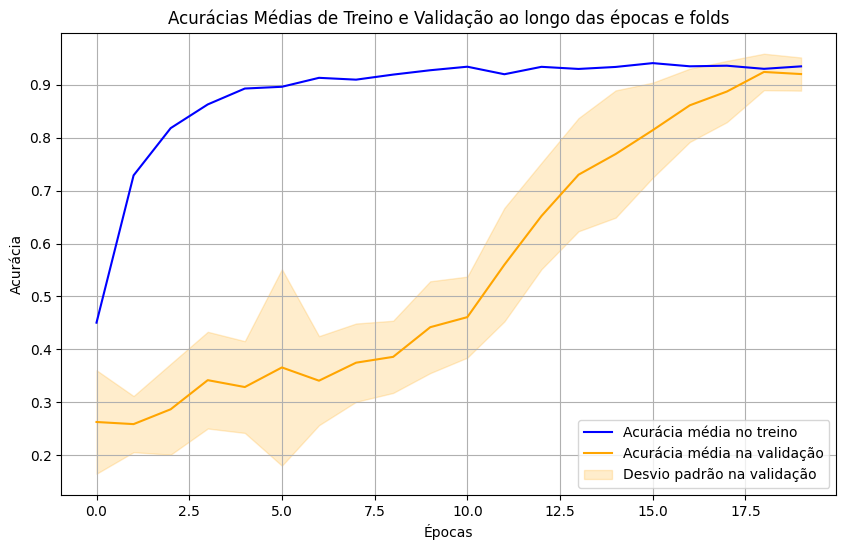

In [77]:
# Calcular a média e o desvio padrão
mean_train_accuracy = np.mean(train_accuracies, axis=0)
mean_val_accuracy = np.mean(val_accuracies, axis=0)
std_val_accuracy = np.std(val_accuracies, axis=0)

# Plotar as curvas de acurácia
plt.figure(figsize=(10, 6))
plt.plot(mean_train_accuracy, label='Acurácia média no treino', color='blue')
plt.plot(mean_val_accuracy, label='Acurácia média na validação', color='orange')
plt.fill_between(range(num_epochs),
                 mean_val_accuracy - std_val_accuracy,
                 mean_val_accuracy + std_val_accuracy,
                 color='orange', alpha=0.2, label='Desvio padrão na validação')
plt.title('Acurácias Médias de Treino e Validação ao longo das épocas e folds')
plt.xlabel('Épocas')                                                 
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)
plt.show()

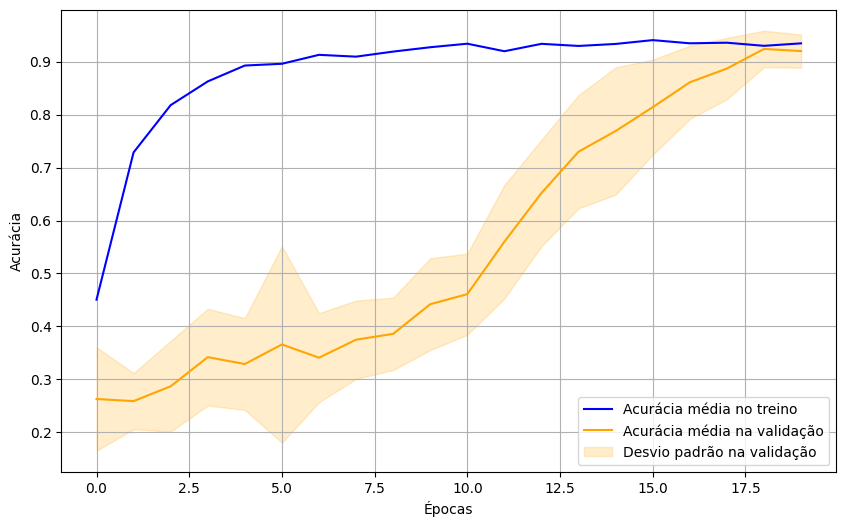

In [78]:
# Calcular a média e o desvio padrão
mean_train_accuracy = np.mean(train_accuracies, axis=0)
mean_val_accuracy = np.mean(val_accuracies, axis=0)
std_val_accuracy = np.std(val_accuracies, axis=0)

# Plotar as curvas de acurácia
plt.figure(figsize=(10, 6))
plt.plot(mean_train_accuracy, label='Acurácia média no treino', color='blue')
plt.plot(mean_val_accuracy, label='Acurácia média na validação', color='orange')
plt.fill_between(range(num_epochs),
                 mean_val_accuracy - std_val_accuracy,
                 mean_val_accuracy + std_val_accuracy,
                 color='orange', alpha=0.2, label='Desvio padrão na validação')
#plt.title('Acurácias Médias de Treino e Validação ao longo das épocas e folds')
plt.xlabel('Épocas')                                                 
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)
plt.show()

Interpretação:

A curva de training accuracy mostra como o modelo está aprendendo no conjunto de treino ao longo das épocas.
A curva de validation accuracy indica o desempenho em dados não vistos (validação).
Desvio padrão (opcional): A faixa sombreada indica a variação entre os diferentes folds, o que ajuda a avaliar a consistência.

In [79]:
def plot_training_accuracy(history, title = True):
    # Verifica se 'accuracy' está disponível no histórico
    if 'accuracy' not in history.history:
        print("Accuracy data not found in history. Check if the metric was included during compilation.")
        return
    
    # Plotar a acurácia do treino
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Accurácia no treinamento')
    if title:
        plt.title('Acurácia no Treinamento')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_training_loss(history, title = True):
    # Verifica se 'loss' está disponível no histórico
    if 'loss' not in history.history:
        print("Loss data not found in history. Check if the metric was included during compilation.")
        return
    
    # Plotar a perda do treino
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Perda no treinamento',  marker='o', color='red')
    if title:
        plt.title('Perda no Treinamento')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()
    plt.grid(True)
    plt.show()


In [80]:
def plot_training_loss(history, title=True):
    # Verifica se 'loss' está disponível no histórico
    if 'loss' not in history.history:
        print("Loss data not found in history. Check if the metric was included during compilation.")
        return
    
    # Recupera os valores de perda
    losses = history.history['loss']
    
    # Plotar a perda do treino
    plt.figure(figsize=(10, 6))
    plt.plot(losses, label='Perda no treinamento', marker='o', color='indianred')
    
    # Adicionar os valores de perda no gráfico
    for i, loss in enumerate(losses):
        plt.annotate(f"{loss:.2f}", (i, loss), textcoords="offset points", xytext=(0, 7), ha='center', fontsize=10)
    
    # Configurações do gráfico
    if title:
        plt.title('Perda no Treinamento', fontsize=16)
    plt.xlabel('Épocas', fontsize=14)
    plt.ylabel('Perda', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.5)
    plt.tight_layout()
    
    # Exibir o gráfico
    plt.show()


In [81]:
def plot_training_accuracy(history, title = True):
    if 'accuracy' not in history.history:
        print("Accuracy data not found in history. Check if the metric was included during compilation.")
        return

    # Plotar a acurácia do treino
    plt.figure(figsize=(10, 6))
    accuracies = history.history['accuracy']

    # Plotando a curva de acurácia
    plt.plot(accuracies, label='Acurácia no treinamento', marker='o', color='royalblue')

    # Adicionar valores de acurácia no gráfico
    for i, acc in enumerate(accuracies):
        plt.annotate(f"{acc:.2f}", (i, acc), textcoords="offset points", xytext=(0, 7), ha='center', fontsize=10)

    # Configurações do gráfico
    if title:
        plt.title('Acurácia no Treinamento', fontsize=16)
    plt.xlabel('Épocas', fontsize=14)
    plt.ylabel('Acurácia', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.4)
    plt.tight_layout()

    # Exibir o gráfico
    plt.show()


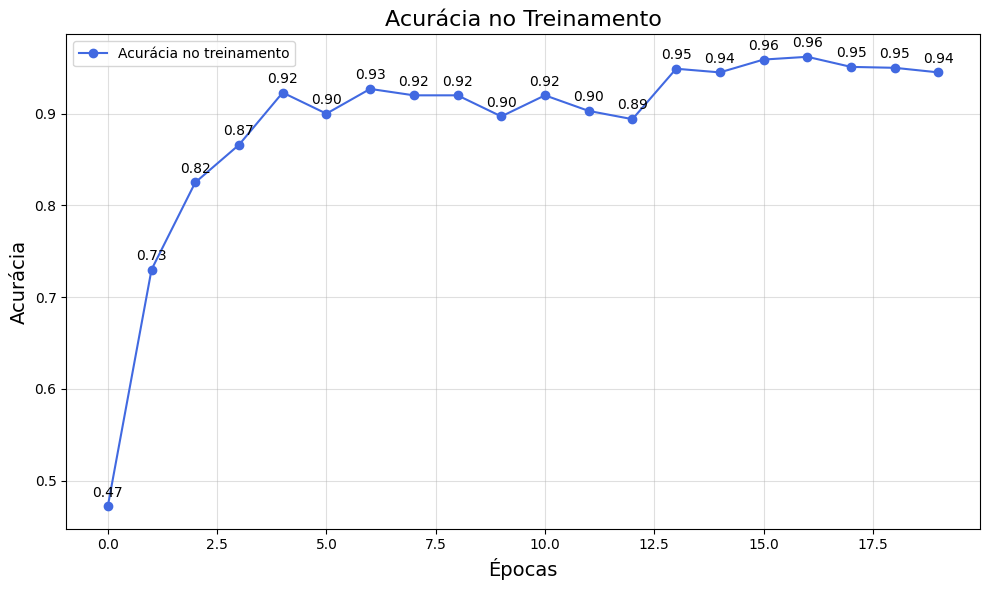

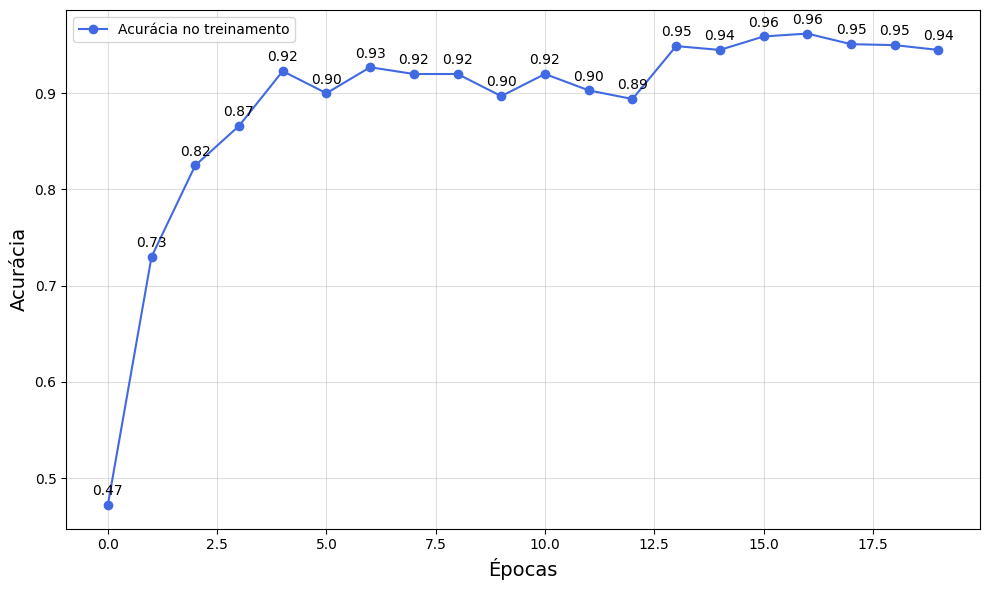

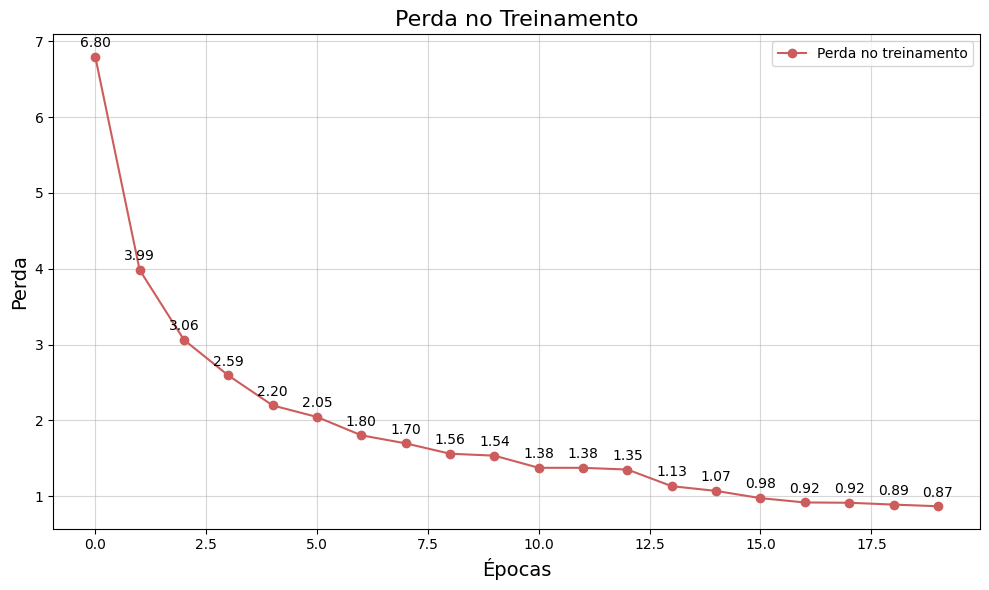

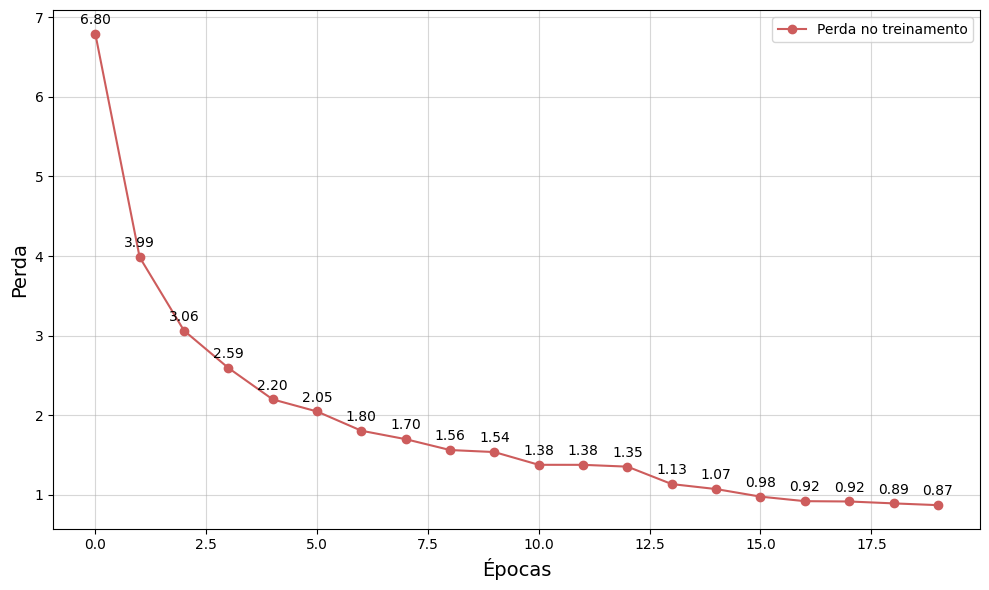

In [82]:
# Chamar a função com o histórico do treinamento final
plot_training_accuracy(history_final)
plot_training_accuracy(history_final, False)

# Chamar a função com o histórico do treinamento final
plot_training_loss(history_final)
plot_training_loss(history_final, False)

Interpretação:

Observe o comportamento do loss durante as épocas:
Um decaimento gradual e consistente é sinal de um bom ajuste.
Se o loss oscila ou estaciona cedo, pode ser necessário ajustar hiperparâmetros (como taxa de aprendizado ou regularização).

In [83]:
from matplotlib import colormaps
list(colormaps)

['magma',
 'inferno',
 'plasma',
 'viridis',
 'cividis',
 'twilight',
 'twilight_shifted',
 'turbo',
 'Blues',
 'BrBG',
 'BuGn',
 'BuPu',
 'CMRmap',
 'GnBu',
 'Greens',
 'Greys',
 'OrRd',
 'Oranges',
 'PRGn',
 'PiYG',
 'PuBu',
 'PuBuGn',
 'PuOr',
 'PuRd',
 'Purples',
 'RdBu',
 'RdGy',
 'RdPu',
 'RdYlBu',
 'RdYlGn',
 'Reds',
 'Spectral',
 'Wistia',
 'YlGn',
 'YlGnBu',
 'YlOrBr',
 'YlOrRd',
 'afmhot',
 'autumn',
 'binary',
 'bone',
 'brg',
 'bwr',
 'cool',
 'coolwarm',
 'copper',
 'cubehelix',
 'flag',
 'gist_earth',
 'gist_gray',
 'gist_heat',
 'gist_ncar',
 'gist_rainbow',
 'gist_stern',
 'gist_yarg',
 'gnuplot',
 'gnuplot2',
 'gray',
 'hot',
 'hsv',
 'jet',
 'nipy_spectral',
 'ocean',
 'pink',
 'prism',
 'rainbow',
 'seismic',
 'spring',
 'summer',
 'terrain',
 'winter',
 'Accent',
 'Dark2',
 'Paired',
 'Pastel1',
 'Pastel2',
 'Set1',
 'Set2',
 'Set3',
 'tab10',
 'tab20',
 'tab20b',
 'tab20c',
 'grey',
 'gist_grey',
 'gist_yerg',
 'Grays',
 'magma_r',
 'inferno_r',
 'plasma_r',
 'viri

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/8 ━━━━━━━━━━━━━━━━━━━━ 2s 338ms/step

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
y_pred
[[0.0079805  0.8539321  0.08153481 0.0246636  0.03188898]
 [0.965452   0.00324117 0.01701611 0.01047965 0.00381109]
 [0.10990645 0.0139865  0.0085207  0.85812855 0.00945775]
 ...
 [0.96413434 0.0033923  0.0176157  0.01087621 0.00398159]
 [0.03077282 0.00429874 0.00188901 0.9602819  0.00275754]
 [0.020216   0.06778724 0.88975537 0.00458586 0.0176556 ]]
250
y_test
[[0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]]
250
y_test_classes
[1 0 3 3 3 4 1 0 1 4 2 1 3 4 2 4 1 3 0 0 2 2 0 4 2 4 0 2 2 4 1 3 4 0 2 0 3
 1 0 1 3 2 0 0 3 4 1 1 2 2 3 1 0 0 4 0 2 3 1 3 2 2 0 4 4 2 3 0 0 2 4 3 4 3
 2 0 0 1 2 3 2 2 1 1 0 2 4 2 0 4 4 0 3 2 4 0 3 3 4 3 3 3 0 2 3 4 4 4 2 1 0
 1 1 0 2 4 3 0 2 1 4 4 3 1 4 0 2 4 2 0 2 3 1 2 1 1 2 1 1 2 4 2 0 4 4 0 4 0
 0 4 0 2 2 3 2 4 4 2 4 1 4 1 3 4 3 1 4 2 2 2 2 2 3 2 0 2 4 0 0 3 2 0 2 1 3
 0 1 1 2 3 3 2 1 0 3 3 4 3 1 2 1 1 3 1 1 4 2 1 2 1 0 2 3 2 1 0 1 0 0 4 1 1
 2 1 0 

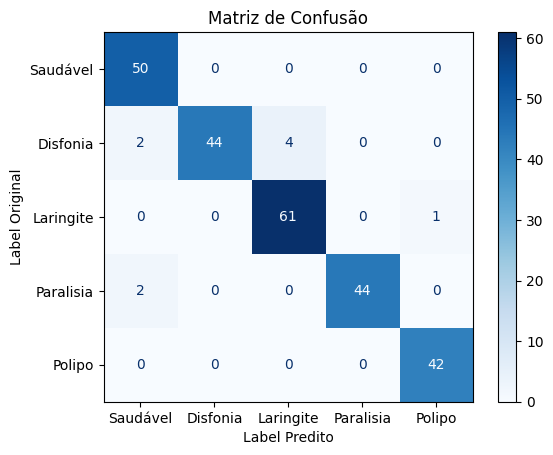

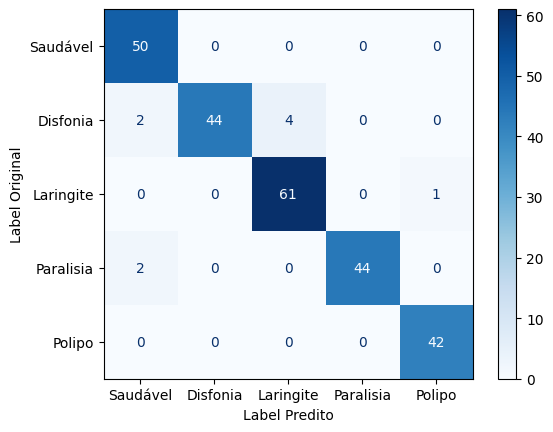

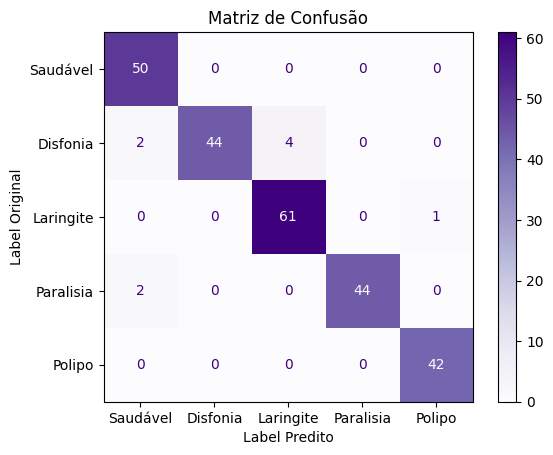

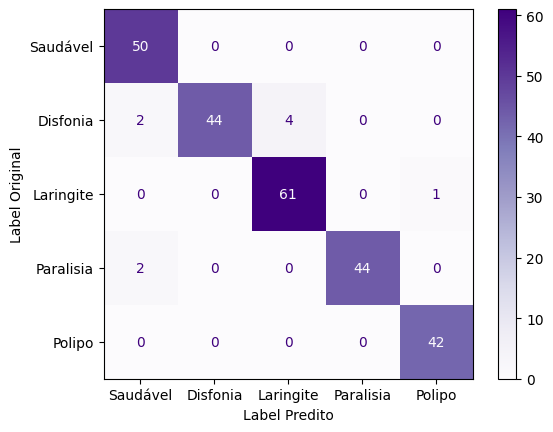

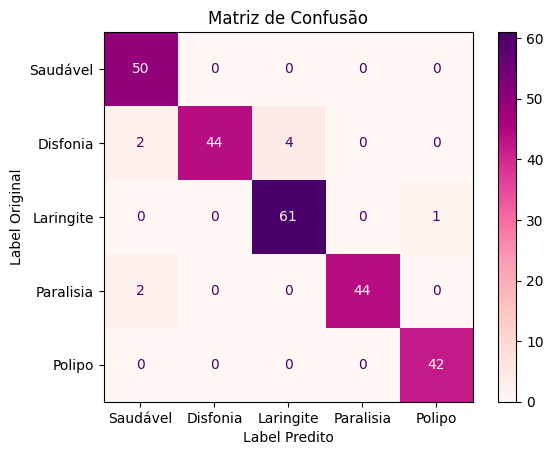

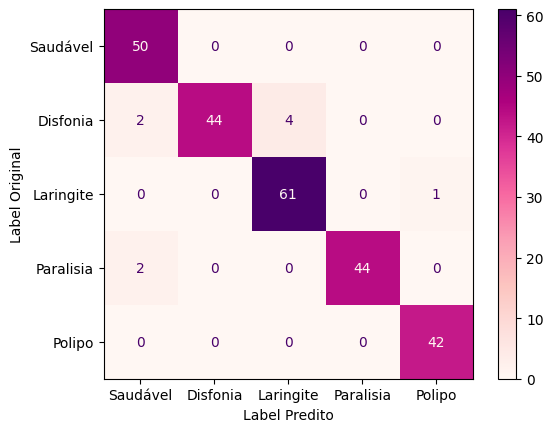

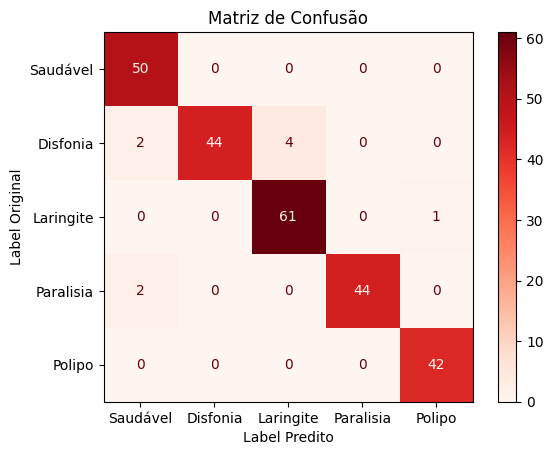

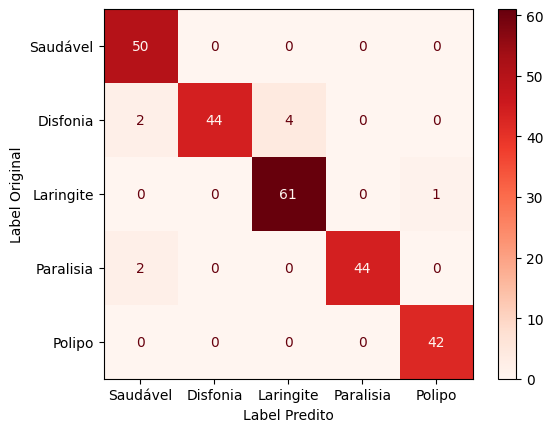

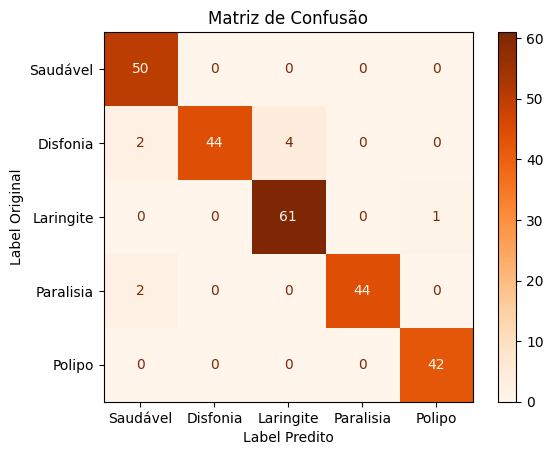

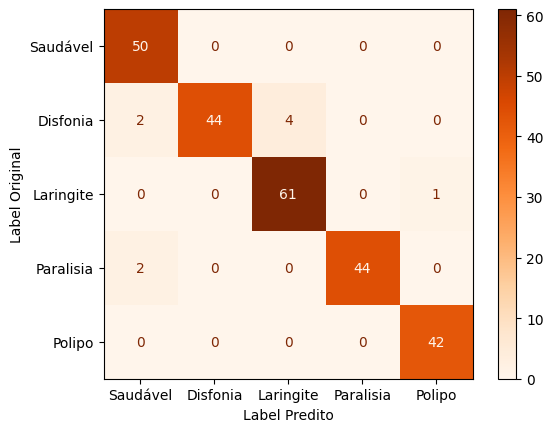

In [84]:
# Prever no conjunto de teste
y_pred = final_model.predict(X_test)
print('y_pred')
print(y_pred)
print(len(y_pred))


print('y_test')
print(y_test)
print(len(y_test))


# Converter para rótulos de classe
y_test_classes = np.argmax(y_test, axis=1)  # De one-hot para índices de classe
y_pred_classes = np.argmax(y_pred, axis=1)  # De probabilidades para índices de classe
print('y_test_classes')
print(y_test_classes)

print('y_pred_classes')
print(y_pred_classes)

# Criar matriz de confusão
cm = confusion_matrix(y_test_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Saudável', 'Disfonia', 'Laringite', 'Paralisia', 'Polipo'])


# Plotar matriz
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.xlabel('Label Predito')
plt.ylabel('Label Original')
plt.show()

disp.plot(cmap=plt.cm.Blues)
#plt.title('Matriz de Confusão')
plt.xlabel('Label Predito')
plt.ylabel('Label Original')
plt.show()

disp.plot(cmap=plt.cm.Purples)
plt.title('Matriz de Confusão')
plt.xlabel('Label Predito')
plt.ylabel('Label Original')
plt.show()

disp.plot(cmap=plt.cm.Purples)
#plt.title('Matriz de Confusão')
plt.xlabel('Label Predito')
plt.ylabel('Label Original')
plt.show()

disp.plot(cmap=plt.cm.RdPu)
plt.title('Matriz de Confusão')
plt.xlabel('Label Predito')
plt.ylabel('Label Original')
plt.show()

disp.plot(cmap=plt.cm.RdPu)
#plt.title('Matriz de Confusão')
plt.xlabel('Label Predito')
plt.ylabel('Label Original')
plt.show()

disp.plot(cmap=plt.cm.Reds)
plt.title('Matriz de Confusão')
plt.xlabel('Label Predito')
plt.ylabel('Label Original')
plt.show()

disp.plot(cmap=plt.cm.Reds)
#plt.title('Matriz de Confusão')
plt.xlabel('Label Predito')
plt.ylabel('Label Original')
plt.show()

disp.plot(cmap=plt.cm.Oranges)
plt.title('Matriz de Confusão')
plt.xlabel('Label Predito')
plt.ylabel('Label Original')
plt.show()

disp.plot(cmap=plt.cm.Oranges)
#plt.title('Matriz de Confusão')
plt.xlabel('Label Predito')
plt.ylabel('Label Original')
plt.show()


In [85]:
y_pred

array([[0.0079805 , 0.8539321 , 0.08153481, 0.0246636 , 0.03188898],
       [0.965452  , 0.00324117, 0.01701611, 0.01047965, 0.00381109],
       [0.10990645, 0.0139865 , 0.0085207 , 0.85812855, 0.00945775],
       ...,
       [0.96413434, 0.0033923 , 0.0176157 , 0.01087621, 0.00398159],
       [0.03077282, 0.00429874, 0.00188901, 0.9602819 , 0.00275754],
       [0.020216  , 0.06778724, 0.88975537, 0.00458586, 0.0176556 ]],
      dtype=float32)

In [87]:
def plot_roc_curve(title=True):
     from sklearn.metrics import roc_curve, auc
     from sklearn.preprocessing import label_binarize
     import matplotlib.pyplot as plt
     import numpy as np

     # Exemplo: Classes possíveis
     n_classes = y_test.shape[1]  # Assumindo que y_test está one-hot-encoded

     # Inicializar variáveis para armazenar curvas ROC e AUC
     fpr = dict()
     tpr = dict()
     roc_auc = dict()

     # Calcular ROC para cada classe individualmente
     for i in range(n_classes):
          fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])  # One-vs-Rest
          roc_auc[i] = auc(fpr[i], tpr[i])

     # Plotar a curva ROC para cada classe
     plt.figure(figsize=(10, 8))
     colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown']  # Defina cores para cada classe

     for i in range(n_classes):
          if i == 0:
                    lb = 'Saudável'
          elif i == 1:
               lb = 'Disfonia'
          elif i == 2:
               lb = 'Laringite'
          elif i == 3:
               lb = 'Paralisia'
          elif i == 4:
               lb = 'Polipo'

          if 1 == 1:
               plt.plot(
                    fpr[i], tpr[i],
                    color=colors[i % len(colors)],
                    label=f'{lb} (AUC = {roc_auc[i]:.2f})'
          )

     # Adicionar linha diagonal (aleatório)
     plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Classificador aleatório')

     if title:
          plt.title('Curva ROC Multi-Classe')
     plt.xlabel('Taxa de Falsos Positivos (FPR)')
     plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
     plt.legend(loc='lower right')
     plt.grid(True)
     plt.show()


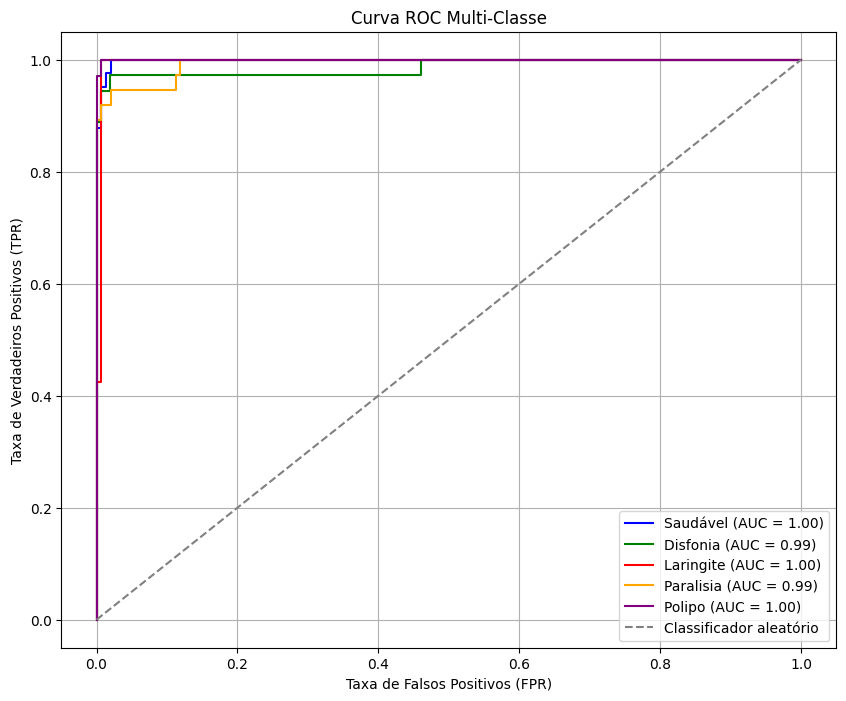

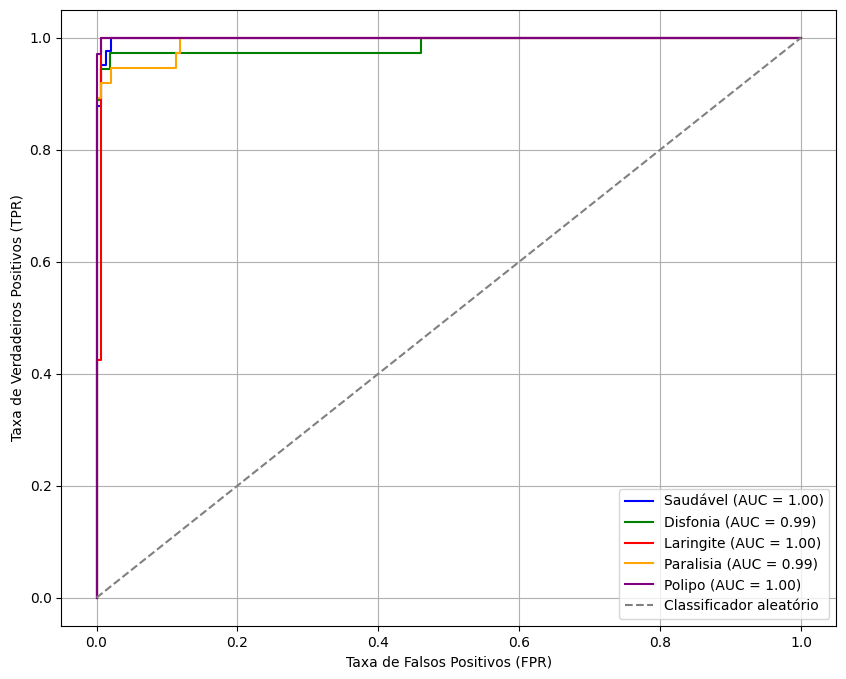

In [195]:
plot_roc_curve()
plot_roc_curve(False)

In [94]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Exemplo: Classes possíveis
n_classes = y_test.shape[1]  # Assumindo que y_test está one-hot-encoded

# Inicializar variáveis para armazenar curvas ROC e AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calcular ROC para cada classe individualmente
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])  # One-vs-Rest
    roc_auc[i] = auc(fpr[i], tpr[i])



In [95]:
# Média ponderada da AUC (usando frequência de cada classe)
weights = np.sum(y_test, axis=0) / len(y_test)  # Frequência de cada classe
roc_auc_weighted = np.average([roc_auc[i] for i in range(5)], weights=weights)
print(f"Média ponderada da AUC: {roc_auc_weighted:.2f}")


Média ponderada da AUC: 1.00


Interpretação:
Curva próxima do canto superior esquerdo: Indica alta performance.
AUC próximo de 1.0: Excelente desempenho.
AUC próximo de 0.5: Desempenho igual a um chute aleatório.

In [96]:
# Carregar o histórico salvo com pickle
with open(path_historicos_implementacao + '/' + 'model_cnn_rnn_masculino_multiclasse_history_final.pkl', 'rb') as file:
    loaded_history = pickle.load(file)

print(loaded_history)  # Dicionário com os dados do histórico


{'accuracy': [0.3954285681247711, 0.5565714240074158, 0.7611428499221802, 0.8251428604125977, 0.8754285573959351, 0.9062857031822205, 0.8982856869697571, 0.9108571410179138, 0.9325714111328125, 0.9268571138381958, 0.954285740852356, 0.954285740852356, 0.9028571248054504, 0.9417142868041992, 0.9554286003112793, 0.9577142596244812, 0.9588571190834045, 0.9554286003112793, 0.973714292049408, 0.954285740852356], 'categorical_accuracy': [0.3954285681247711, 0.5565714240074158, 0.7611428499221802, 0.8251428604125977, 0.8754285573959351, 0.9062857031822205, 0.8982856869697571, 0.9108571410179138, 0.9325714111328125, 0.9268571138381958, 0.954285740852356, 0.954285740852356, 0.9028571248054504, 0.9417142868041992, 0.9554286003112793, 0.9577142596244812, 0.9588571190834045, 0.9554286003112793, 0.973714292049408, 0.954285740852356], 'loss': [7.942531108856201, 5.891875743865967, 4.503269672393799, 3.6833693981170654, 3.1491880416870117, 2.8225390911102295, 2.615713357925415, 2.449159622192383, 2.2

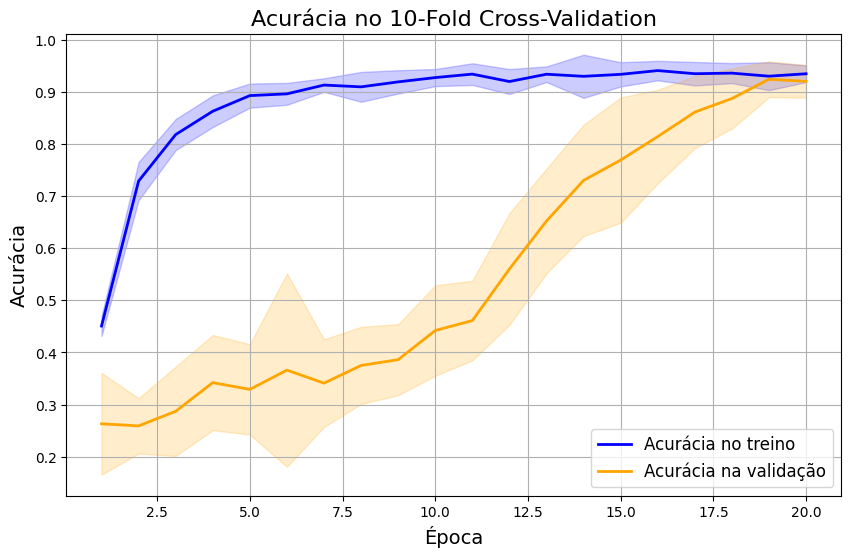

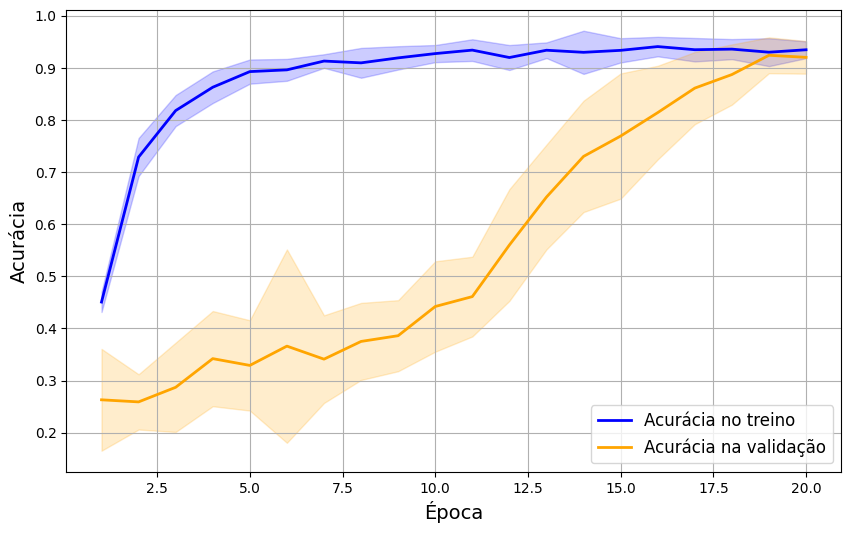

In [97]:
def plot_kfold_accuracy(histories, title=True):
    """
    Plota a curva de acurácia média para treino e validação durante o k-fold cross-validation.

    :param histories: Lista de objetos 'history' retornados por model.fit para cada fold.
    """
    # Inicializar listas para armazenar as métricas de treino e validação
    training_accuracies = []
    validation_accuracies = []

    # Iterar pelos históricos de cada fold
    for history in histories:
        training_accuracies.append(history.history['accuracy'])
        if 'val_accuracy' in history.history:
            validation_accuracies.append(history.history['val_accuracy'])

    # Calcular as médias e desvios padrão por época
    training_accuracies = np.array(training_accuracies)
    validation_accuracies = np.array(validation_accuracies)

    mean_train = np.mean(training_accuracies, axis=0)
    std_train = np.std(training_accuracies, axis=0)
    
    mean_val = np.mean(validation_accuracies, axis=0)
    std_val = np.std(validation_accuracies, axis=0)

    # Plotar as curvas de acurácia
    epochs = range(1, len(mean_train) + 1)
    plt.figure(figsize=(10, 6))
    
    # Acurácia de treino
    plt.plot(epochs, mean_train, label='Acurácia no treino', color='blue', linewidth=2)
    plt.fill_between(epochs, mean_train - std_train, mean_train + std_train, color='blue', alpha=0.2)
    
    # Acurácia de validação
    plt.plot(epochs, mean_val, label='Acurácia na validação', color='orange', linewidth=2)
    plt.fill_between(epochs, mean_val - std_val, mean_val + std_val, color='orange', alpha=0.2)
    
    # Configurações do gráfico
    if title:
        plt.title('Acurácia no 10-Fold Cross-Validation', fontsize=16)
    plt.xlabel('Época', fontsize=14)
    plt.ylabel('Acurácia', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

plot_kfold_accuracy(histories)
plot_kfold_accuracy(histories, False)
